In [ ]:
!pip install qiskit qiskit_aer ipywidgets matplotlib pylatexenc

**Grover’s Algorithm**

Grover’s algorithm is a quantum search algorithm that finds a marked item in an unsorted database of size $N$ in approximately $\mathcal{O}(\sqrt{N})$ steps, providing a quadratic speedup over classical search methods.

**Key steps:**

1. **Initialization:** Prepare an equal superposition over all possible $n$-qubit states.
2. **Oracle:** Flip the phase of the marked state (the “target”).
3. **Diffuser (Inversion about the mean):** Amplify the probability amplitude of the marked state.
4. **Iteration:** Repeat the Oracle and Diffuser $\approx \frac{\pi}{4} \sqrt{N}$ times.
5. **Measurement:** Measure the qubits to obtain the marked element with high probability.

**Why does Grover’s algorithm require about $\frac{\pi}{4} \sqrt{N}$ iterations instead of just one?**

Grover’s algorithm finds a marked item in an unsorted database of size $N = 2^n$ by **amplitude amplification**. Each iteration of the algorithm consists of two main steps: applying the oracle (which flips the phase of the marked state) and then applying the diffuser (which amplifies the amplitude of the marked state).

* **Single iteration effect:** One iteration performs a small rotation of the quantum state vector in a two-dimensional subspace spanned by the marked state and all other states. This rotation increases the amplitude of the marked state only slightly.

* **Rotation angle per iteration:** The rotation angle $\theta$ per iteration is approximately $\frac{2}{\sqrt{N}}$ radians.

* **Goal:** To maximize the probability of measuring the marked state, the state vector needs to be rotated close to $\frac{\pi}{2}$ (90 degrees) toward the marked state.

* **Number of iterations needed:** The total number of iterations $k$ required satisfies:

  $$
  k \times \theta \approx \frac{\pi}{2} \quad \Rightarrow \quad k \approx \frac{\pi}{2 \theta} \approx \frac{\pi}{4} \sqrt{N}
  $$

* **Interpretation:** Running fewer than $\frac{\pi}{4} \sqrt{N}$ iterations results in insufficient amplification, while running too many causes the amplitude to overshoot and decrease again (oscillating behavior).

Therefore, although a single iteration flips the phase of the marked state and slightly amplifies its amplitude, about $\frac{\pi}{4} \sqrt{N}$ iterations are needed to amplify the amplitude enough for a high probability of successfully measuring the marked state.


In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.quantum_info import Statevector, partial_trace
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt

# Build Grover Oracle
def build_oracle(n, target_bitstring):
    oracle = QuantumCircuit(n)
    for i, bit in enumerate(reversed(target_bitstring)):
        if bit == '0':
            oracle.x(i)
    oracle.h(n-1)
    oracle.mcx(list(range(n-1)), n-1)
    oracle.h(n-1)
    for i, bit in enumerate(reversed(target_bitstring)):
        if bit == '0':
            oracle.x(i)
    oracle = oracle.to_gate()
    oracle.name = f"Oracle for {target_bitstring}"
    return oracle

# Grover Diffuser (Inversion about mean)
def diffuser(n):
    diff = QuantumCircuit(n)
    diff.h(range(n))
    diff.x(range(n))
    diff.h(n-1)
    diff.mcx(list(range(n-1)), n-1)
    diff.h(n-1)
    diff.x(range(n))
    diff.h(range(n))
    diff = diff.to_gate()
    diff.name = "Diffuser"
    return diff

# Full Grover Circuit
def grover_circuit(target, n):
    qc = QuantumCircuit(n, n)
    qc.h(range(n))  # Step 1: Superposition

    # Step 2: Grover iteration (1 time for small n)
    oracle = build_oracle(n, target)
    diff = diffuser(n)
    qc.append(oracle, range(n))
    qc.append(diff, range(n))

    # Step 3: Measure
    qc.measure(range(n), range(n))
    return qc

n_qubits = 3
bitstrings = [format(i, f'0{n_qubits}b') for i in range(2**n_qubits)]

target_dropdown = widgets.Dropdown(
    options=bitstrings,
    value='000',
    description='Target Bitstring:',
    style={'description_width': 'initial'}
)

grover_button = widgets.Button(description="Run Grover's Algorithm")
grover_output = widgets.Output()

def on_grover_clicked(b):
    with grover_output:
        clear_output()
        target = target_dropdown.value
        qc = grover_circuit(target, n_qubits)

        display(qc.draw('mpl'))

        simulator = AerSimulator()
        transpiled = transpile(qc, simulator)
        result = simulator.run(transpiled, shots=1024).result()
        counts = result.get_counts()

        print(f"\nTarget bitstring searched: {target}")
        print("Measurement result (most likely is the marked element):")
        display(plot_histogram(counts))

        print("\nBloch vectors before measurement:")
        state = Statevector.from_instruction(qc.remove_final_measurements(inplace=False))
        for i in range(n_qubits):
            traced = partial_trace(state, [j for j in range(n_qubits) if j != i])
            display(plot_bloch_multivector(traced, title=f"Qubit {i}"))

grover_button.on_click(on_grover_clicked)

display(target_dropdown, grover_button, grover_output)


Dropdown(description='Target Bitstring:', options=('000', '001', '010', '011', '100', '101', '110', '111'), st…

Button(description="Run Grover's Algorithm", style=ButtonStyle())

Output()

Initial state Bloch spheres:


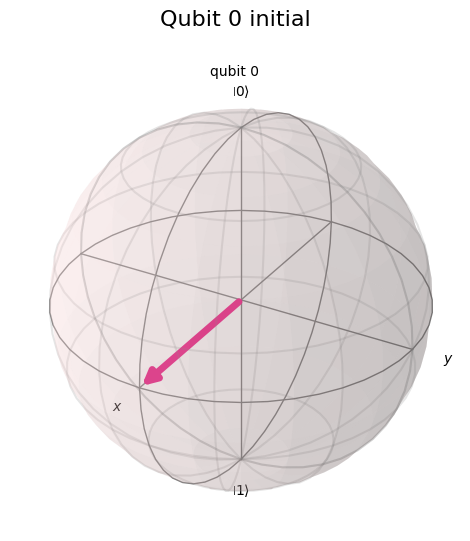

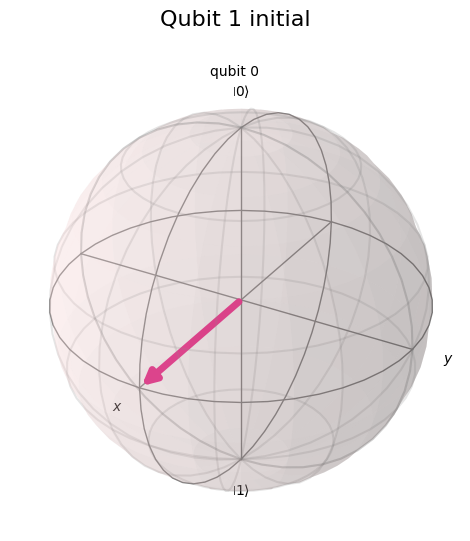

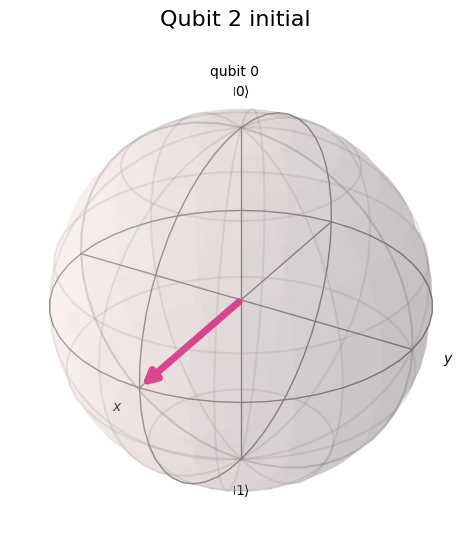

After Oracle in iteration 1:


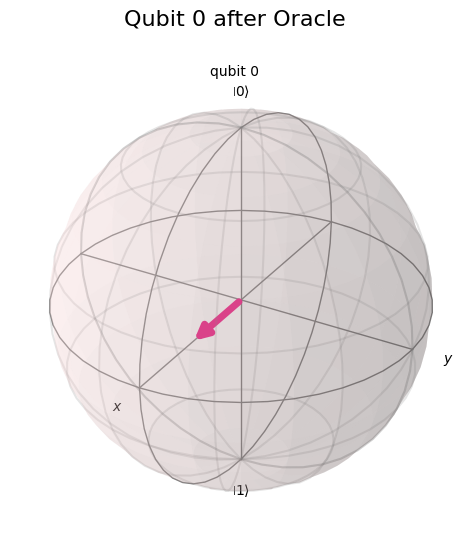

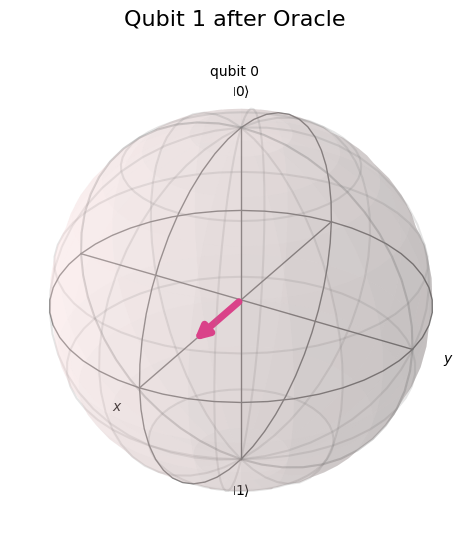

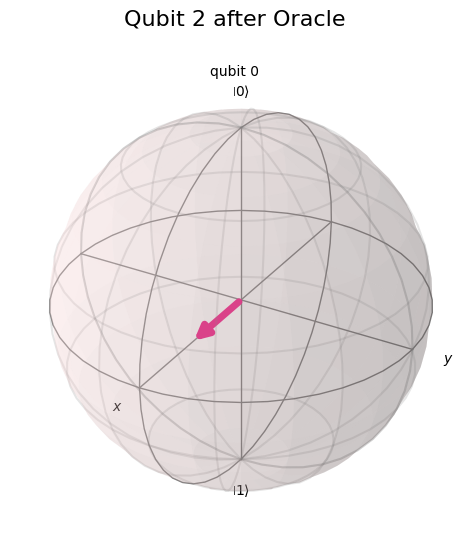

After Diffuser in iteration 1:


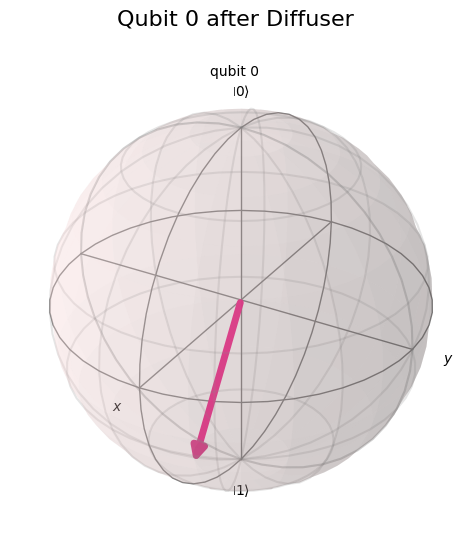

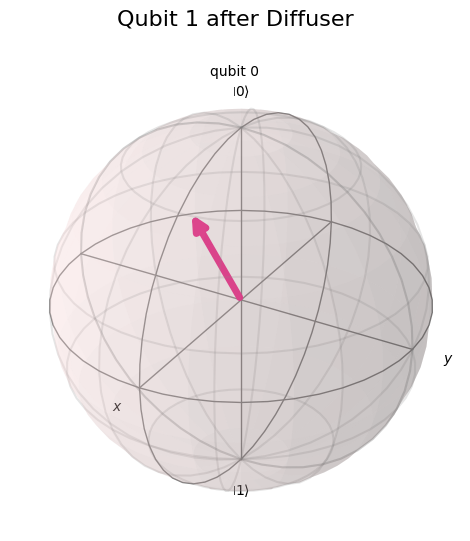

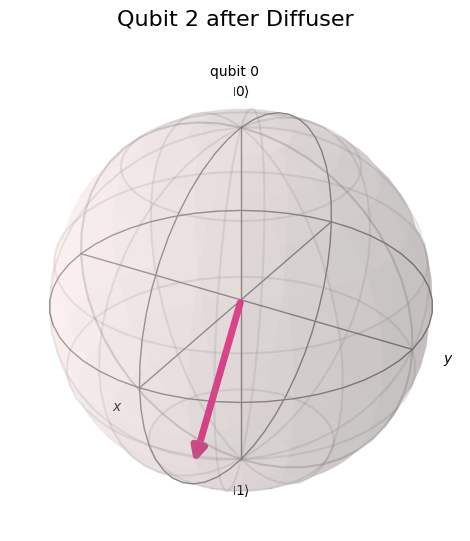

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector, partial_trace
from IPython.display import display, clear_output
import ipywidgets as widgets
import numpy as np

n = 3

marked_element = '101'  # example marked state
iterations = 1  # show for first iteration only

def grover_oracle(n, marked_element):
    qc = QuantumCircuit(n)
    for i, bit in enumerate(reversed(marked_element)):
        if bit == '0':
            qc.x(i)
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    for i, bit in enumerate(reversed(marked_element)):
        if bit == '0':
            qc.x(i)
    return qc

def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

oracle = grover_oracle(n, marked_element).to_gate(label="Oracle")
diffuser = grover_diffuser(n).to_gate(label="Diffuser")

qc = QuantumCircuit(n)
qc.h(range(n))  # initial superposition

state = Statevector.from_instruction(qc)
print("Initial state Bloch spheres:")
for i in range(n):
    reduced = partial_trace(state, [j for j in range(n) if j != i])
    display(plot_bloch_multivector(reduced, title=f"Qubit {i} initial"))

for iter in range(iterations):
    qc.append(oracle, range(n))
    state = Statevector.from_instruction(qc)
    print(f"After Oracle in iteration {iter+1}:")
    for i in range(n):
        reduced = partial_trace(state, [j for j in range(n) if j != i])
        display(plot_bloch_multivector(reduced, title=f"Qubit {i} after Oracle"))

    qc.append(diffuser, range(n))
    state = Statevector.from_instruction(qc)
    print(f"After Diffuser in iteration {iter+1}:")
    for i in range(n):
        reduced = partial_trace(state, [j for j in range(n) if j != i])
        display(plot_bloch_multivector(reduced, title=f"Qubit {i} after Diffuser"))


In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display, clear_output
import ipywidgets as widgets
import numpy as np

# Parameters
n = 8
N = 2**n
iterations = int(np.floor(np.pi/4 * np.sqrt(N)))

# Oracle: Phase flip for the marked state
def grover_oracle(n, marked_element):
    qc = QuantumCircuit(n)
    for i, bit in enumerate(reversed(marked_element)):
        if bit == '0':
            qc.x(i)
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    for i, bit in enumerate(reversed(marked_element)):
        if bit == '0':
            qc.x(i)
    return qc

# Diffuser
def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    return qc

# Grover circuit builder
def grover_circuit(n, marked_element):
    qc = QuantumCircuit(n, n)
    qc.h(range(n))
    oracle = grover_oracle(n, marked_element)
    diffuser = grover_diffuser(n)
    for _ in range(iterations):
        qc.append(oracle.to_gate(), range(n))
        qc.append(diffuser.to_gate(), range(n))
    qc.measure(range(n), range(n))
    return qc


text_input = widgets.Text(
    value='00000000',
    placeholder='Enter 8-bit string (e.g., 10101010)',
    description='Marked String:',
    style={'description_width': 'initial'},
)

button = widgets.Button(description="Run Grover's Algorithm")
output = widgets.Output()


def on_button_clicked(b):
    with output:
        clear_output()
        marked = text_input.value.strip()
        if len(marked) != 8 or not all(c in '01' for c in marked):
            print("❌ Please enter a valid 8-bit binary string (e.g., 10101010).")
            return
        print(f"Running Grover's Algorithm for marked string: {marked}\n")

        qc = grover_circuit(n, marked)
        display(qc.draw('mpl'))

        simulator = AerSimulator()
        compiled = transpile(qc, simulator)
        result = simulator.run(compiled).result()
        counts = result.get_counts()

        display(plot_histogram(counts))


        most_likely = max(counts, key=counts.get)
        print(f"Most likely result (peak in histogram): {most_likely}")
        print("✅ Success!" if most_likely == marked else "❌ Not exact. Try again or rerun!")


button.on_click(on_button_clicked)
display(widgets.VBox([text_input, button, output]))


**PENNYLANE CODE**

PennyLane often behaves differently from Qiskit due to:

*   Bit ordering (endianness) differences between PennyLane and Qiskit.

*   The internal behavior of qml.MultiControlledX, which sometimes leads to minor probability leaks unless constructed very carefully.

*   Circuit fidelity: Qiskit has highly optimized gates (especially MCX), while PennyLane builds them out from basic gates unless you're using a plugin with native support (like qiskit.aer, lightning.qubit).

In [ ]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 77.6 MB/s eta 0:00:00


In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Parameters
n = 8
N = 2**n
iterations = int(np.floor(np.pi/4 * np.sqrt(N)))

# Device
dev = qml.device("default.qubit", wires=n, shots=1024)

# Oracle
def apply_oracle(marked):
    for i, bit in enumerate(reversed(marked)):
        if bit == '0':
            qml.PauliX(wires=i)

    # Hadamard on last qubit before MCX (to make MCX act like MCZ)
    qml.Hadamard(wires=n-1)
    qml.MultiControlledX(wires=list(range(n - 1)) + [n - 1])
    qml.Hadamard(wires=n-1)

    for i, bit in enumerate(reversed(marked)):
        if bit == '0':
            qml.PauliX(wires=i)


# Diffuser
def diffuser():
    for i in range(n):
        qml.Hadamard(wires=i)
        qml.PauliX(wires=i)

    # Hadamard on last qubit before MCX
    qml.Hadamard(wires=n-1)
    qml.MultiControlledX(wires=list(range(n - 1)) + [n - 1])
    qml.Hadamard(wires=n-1)

    for i in range(n):
        qml.PauliX(wires=i)
        qml.Hadamard(wires=i)


# Grover circuit
@qml.qnode(dev)
def grover_circuit(marked):
    for i in range(n):
        qml.Hadamard(wires=i)
    for _ in range(iterations):
        apply_oracle(marked)
        diffuser()
    return qml.counts(wires=range(n))

# Widgets
text_input = widgets.Text(
    value='00000000',
    placeholder='Enter 8-bit string (e.g., 10101010)',
    description='Marked String:',
    style={'description_width': 'initial'},
)

button = widgets.Button(description="Run Grover's Algorithm")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        marked = text_input.value.strip()
        if len(marked) != 8 or not all(c in '01' for c in marked):
            print("❌ Please enter a valid 8-bit binary string (e.g., 10101010).")
            return

        print(f"Running Grover's Algorithm for marked string: {marked}\n")
        counts = grover_circuit(marked)

        # Plot histogram
        keys = list(counts.keys())
        values = [counts[k] for k in keys]
        plt.figure(figsize=(10,4))
        plt.bar(keys, values, color='skyblue')
        plt.xticks(rotation=90)
        plt.title("Grover's Algorithm Measurement Result")
        plt.xlabel("Measured State")
        plt.ylabel("Counts")
        plt.grid(True)
        plt.show()

        most_likely = max(counts, key=counts.get)

        # Debug comparison with reversed bits for better readability
        print(f"Most likely result (peak in histogram): {most_likely[::-1]}")
        print(f"Input marked string: {marked}")

        if most_likely[::-1].strip() == marked.strip():
            print("✅ Success!")
        else:
            print("❌ Not exact. Try again or rerun!")

button.on_click(on_button_clicked)
display(widgets.VBox([text_input, button, output]))


**GOOGLE CIRQ CODE**

* **Qiskit and Cirq:**
  Both use **little-endian** ordering, meaning **qubit 0 corresponds to the least significant bit (rightmost bit)** in the binary string. So when you read measurement results, qubit 0 is the rightmost bit, qubit 1 the next, and so on.

* **PennyLane:**
  By default, **qubit 0 corresponds to the most significant bit (leftmost bit)** — effectively a **big-endian** convention. This is why you often see reversing the bits (`[::-1]`) when comparing results.

**Why this matters?**

When you input a bitstring like `"00001111"`:

* In **Qiskit/Cirq**, the bitstring means:

  * qubit 0 = 1 (rightmost bit)
  * qubit 7 = 0 (leftmost bit)

* In **PennyLane**, the indexing is reversed:

  * qubit 0 = 0 (leftmost bit)
  * qubit 7 = 1 (rightmost bit)


In [ ]:
!pip install cirq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.1/425.1 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 86.7 MB/s eta 0:00:00


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Parameters
n = 8
N = 2**n
iterations = int(np.floor(np.pi/4 * np.sqrt(N)))

qubits = cirq.LineQubit.range(n)

def apply_oracle(marked, circuit):
    for i, bit in enumerate(marked):
        if bit == '0':
            circuit.append(cirq.X(qubits[n - 1 - i]))

    # Multi-controlled Z using cirq.ControlledGate (controlled Z with n-1 controls)
    # To do this efficiently, we use cirq.Z on last qubit controlled by all others:
    controls = qubits[:-1]
    target = qubits[-1]
    circuit.append(cirq.Z(target).controlled_by(*controls))

    # Flip back qubits where bit is 0
    for i, bit in enumerate(reversed(marked)):
        if bit == '0':
            circuit.append(cirq.X(qubits[i]))

def diffuser(circuit):
    # Apply Hadamard and X to all qubits
    for q in qubits:
        circuit.append(cirq.H(q))
        circuit.append(cirq.X(q))

    # Multi-controlled Z as diffuser
    controls = qubits[:-1]
    target = qubits[-1]
    circuit.append(cirq.Z(target).controlled_by(*controls))

    # Apply X and Hadamard to all qubits again
    for q in qubits:
        circuit.append(cirq.X(q))
        circuit.append(cirq.H(q))

def grover_circuit(marked):
    circuit = cirq.Circuit()

    # Initialize all qubits in superposition
    for q in qubits:
        circuit.append(cirq.H(q))

    # Grover iterations
    for _ in range(iterations):
        apply_oracle(marked, circuit)
        diffuser(circuit)

    # Measurement
    circuit.append(cirq.measure(*qubits, key='result'))
    return circuit

# Widgets
text_input = widgets.Text(
    value='00000000',
    placeholder='Enter 8-bit string (e.g., 10101010)',
    description='Marked String:',
    style={'description_width': 'initial'},
)

button = widgets.Button(description="Run Grover's Algorithm")
output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        marked = text_input.value.strip()
        if len(marked) != 8 or not all(c in '01' for c in marked):
            print("❌ Please enter a valid 8-bit binary string (e.g., 10101010).")
            return

        print(f"Running Grover's Algorithm for marked string: {marked}\n")

        circuit = grover_circuit(marked)
        simulator = cirq.Simulator()
        result = simulator.run(circuit, repetitions=1024)

        # Extract measurement results
        measurements = result.measurements['result']
        bitstrings = [''.join(str(bit) for bit in meas) for meas in measurements]

        # Count occurrences
        from collections import Counter
        counts = Counter(bitstrings)

        # Plot histogram
        keys = list(counts.keys())
        values = [counts[k] for k in keys]
        plt.figure(figsize=(10,4))
        plt.bar(keys, values, color='skyblue')
        plt.xticks(rotation=90)
        plt.title("Grover's Algorithm Measurement Result (Cirq)")
        plt.xlabel("Measured State")
        plt.ylabel("Counts")
        plt.grid(True)
        plt.show()

        most_likely = max(counts, key=counts.get)

        # Debug comparison with reversed bits for better readability
        print(f"Most likely result (peak in histogram): {most_likely[::-1]}")
        print(f"Input marked string: {marked}")

        if most_likely[::-1].strip() == marked.strip():
            print("✅ Success!")
        else:
            print("❌ Not exact. Try again or rerun!")

button.on_click(on_button_clicked)
display(widgets.VBox([text_input, button, output]))
